In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import cv2
from matplotlib import font_manager, rc

import utils

from datetime import datetime
from random import randint

import random

testNUM = 2
classNUM = 21


path_test = r'C:\Users\HSJung\jupyterNotebook\01_Wom_Classification\post_data' #data path
path_ckpt = os.path.join('checkpoint')

label_list = ['팬츠 L3 (슬림)','스커트 L2','팬츠 L1','스커트 L1','팬츠 L3 (일자)',
        '?코트','후드 코트(패딩) L1','?재킷','바람막이','야구점퍼',
        '후드 자켓 L1','가디건 L1','반팔 드레스 L2','긴팔 드레스 L1','민소매 드레스 L2',
        '긴팔티셔츠 L1','폴로티셔츠','블라우스','반팔티셔츠','피케티셔츠','오프숄더']

#한글을 출력하기 위한 부분
location_font = r"C:\Windows\Fonts\NanumSquareRoundB.ttf"
font_name = font_manager.FontProperties(fname=location_font).get_name()
rc('font', family='NanumSquareRound')

C:\Users\HSJung\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def image_print(fig, i, img, name):
    #add column for print input images
    ax = fig.add_subplot(1, testNUM, 1 + i, xticks=[], yticks=[])
    #add title that is probable name of type
    ax.set_title(name)
    plt.imshow(img)

In [3]:
def Grad_CAM(vgg, sess, feed_dict, prob):
    answer = np.ndarray(shape=(testNUM),dtype=int32)
    
    for i in range(testNUM):
        answer[i] = np.argsort(prob[i][::-1])
        
    one_hot = tf.sparse_to_dense(answer,[testNUM,classNUM],1.0)
    
    A = vgg.conv5_3
    Y = vgg.fc8
    
    loss = tf.reduce_sum(tf.multiply(Y,one_hot),axis = 1)
    grads = tf.gradients(loss, A)[0]
    
    grads = sess([grads], feed_dict = feed_dict)
    
    return grads

In [109]:
name_imgs = random.sample(os.listdir(path_test),testNUM)
img = np.ndarray(shape=(testNUM,256,256,3), dtype=float)

i = 0
for name_img in name_imgs:
    
    #get a path of image
    print(name_img,'is selected! ')
    #make a list of images
    img[i] = utils.load_image(os.path.join
                              (path_test,name_img),256)
    i += 1

capture one 09588_002_04.jpg is selected! 
02__.JPG is selected! 


C:\Users\HSJung\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


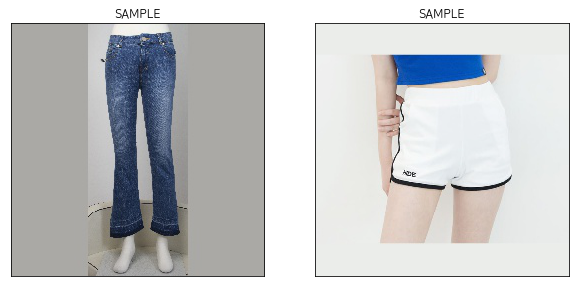

In [110]:
#print sample data
fig = plt.figure(figsize=(round(20/testNUM),round(20/testNUM)))
for i in range(testNUM):
    image_print(fig,i,img[i],"SAMPLE")

program is started
INFO:tensorflow:Restoring parameters from checkpoint\TL-model-22444
2018-09-27 18:46:10.261697  Running starts!
2018-09-27 18:46:14.764070  Running finished!
[[ 4  1  0  7 11 12 14 13 18  5 10  6  2  3 19  8 17  9 15 16 20]
 [ 2 19 17  1 13  0 12  7 11  6 20 10  3  5  9  4 14 18  8 16 15]]


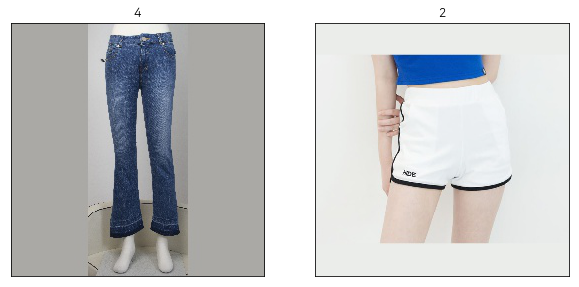

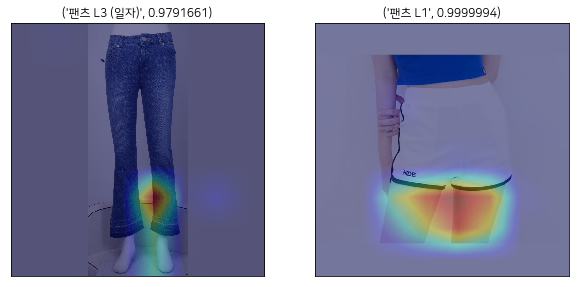

In [111]:
#with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):
with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.8)))) as sess:
        print('program is started')
        #Load meta graph
        saver = tf.train.import_meta_graph(os.path.join(path_ckpt,'TL-model-22444.meta'))
        
        #Load weights
        saver.restore(sess, tf.train.latest_checkpoint(path_ckpt))
        
        #make graph
        graph = tf.get_default_graph()
        
        
        #if you want to get name of pre-trained weights' parameter
        #then remove annotation
        '''
        for op in graph.get_operations():
            print(op.name)
        '''
        
        #set input and ouput
        inputs = graph.get_tensor_by_name("images:0")
        prob_ = graph.get_tensor_by_name("content_vgg/fc8/probability:0")

        #model.pool5
        A = graph.get_tensor_by_name('content_vgg/conv5/pool5:0')
        #model.fc8
        Y = graph.get_tensor_by_name('content_vgg/fc8/fc8_matmul:0')
        
        feed_dict = {inputs: img}

        print(datetime.now(),' Running starts!')
        prob, A_ ,Y_ = sess.run([prob_,A,Y], feed_dict=feed_dict)
        print(datetime.now(),' Running finished!')
        #Show test image and Which label AI decided
        fig = plt.figure(figsize=(10,10))
        
        pred = np.ndarray(shape=(testNUM,classNUM), dtype = int)
        one_hot = np.zeros(shape=(testNUM,classNUM))
        #show TestImage and its label predicted
        for i in range(testNUM):
            pred[i] = np.argsort(prob[i])[::-1]
            one_hot[i][pred[i][0]] = 1.0
            '''
            b,g,r = cv2.split(img[i])
            img_ = cv2.merge([r,g,b])
            '''
            image_print(fig, i, img[i], pred[i][0])

        #set figure for CAM
        fig1 = plt.figure(figsize=(10,10))
        # Conv layer tensor [?,7,7,512] : A
        # [5]-D tensor with target class index set to 1 and rest as 0

        loss = tf.reduce_sum(tf.multiply(Y, one_hot), axis=1)
        grads = tf.gradients(loss, A)[0]

        # Normalizing the gradients
        #norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))
        
        Y, loss, A, grads_val = sess.run([Y, loss, A, grads], feed_dict=feed_dict)
        output = A_ # [testNUM,7,7,512]

        weights = np.mean(grads_val, axis = (1,2))# [testNUM,512]

        
        output = np.transpose(output,[0,3,1,2])
        for j in range(testNUM):
            # Taking a weighted average
            cam = np.zeros(output.shape[2 : 4], dtype = np.float32)# [7,7]
            for i, w in enumerate(weights[j]):
                
                cam += w * output[j][i]
            # Passing through ReLU
            #counterfactual part
            #cam = (-1) * np.minimum(cam, 0)
            #positive part
            cam = np.maximum(cam, 0)
            cam = cam / np.max(cam)
            cam = np.uint8(255 * cam)
            cam = cv2.resize(cam, (256,256))

            heatmap = cv2.applyColorMap(cam,cv2.COLORMAP_JET)
            
            r,g,b = cv2.split(heatmap)
            heatmap = cv2.merge([b,g,r])
            
            result = heatmap * 0.3 + img[j] *(255) * 0.5
            '''
            b, g, r = cv2.split(result)
            result = cv2.merge([r,g,b])
            '''

            image_print(fig1, j, np.uint8(result), (label_list[pred[j][0]],prob[j][pred[j][0]]))
        print(pred)

In [ ]:
def load_image(path, image_WH):
    # load image
    img = skimage.io.imread(path)

    #if file format is 'PNG'
    if (img.shape)[2] is 4:
        img, _ = np.split(ary=img, indices_or_sections=[3], axis=2)
        
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (image_WH, image_WH))
    return resized_img

In [11]:
import skimage
import skimage.io
import skimage.transform

skimage.io.imsave(os.path.join('..','post_data','new.jpg'),load_image('a.jpg',256))


C:\Users\HSJung\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\HSJung\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
